<>:342: SyntaxWarning: invalid escape sequence '\E'
<>:342: SyntaxWarning: invalid escape sequence '\E'
C:\Users\26921\AppData\Local\Temp\ipykernel_23536\89944053.py:342: SyntaxWarning: invalid escape sequence '\E'
  data = pd.read_csv('data\ETTh.csv', usecols=[1], engine='python')


         HUFL
0       5.827
1       5.693
2       5.157
3       5.090
4       5.358
...       ...
17415  -1.674
17416  -5.492
17417   2.813
17418   9.243
17419  10.114

[17420 rows x 1 columns]


C:\Users\26921\AppData\Local\Temp\ipykernel_23536\89944053.py:362: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_8f7uhuge1i\croot\pytorch-select_1717607507421\work\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.Tensor(dataX), torch.Tensor(dataY)
Training LSTM:   0%|          | 0/20 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\rnn.py:911: UserWarning: LSTM with projections is not supported with oneDNN. Using default implementation. (Triggered internally at C:\b\abs_8f7uhuge1i\croot\pytorch-select_1717607507421\work\aten\src\ATen\native\RNN.cpp:1474.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Training mLSTM: 100%|██████████| 20/20 [03:47<00:00, 11.35s/it]


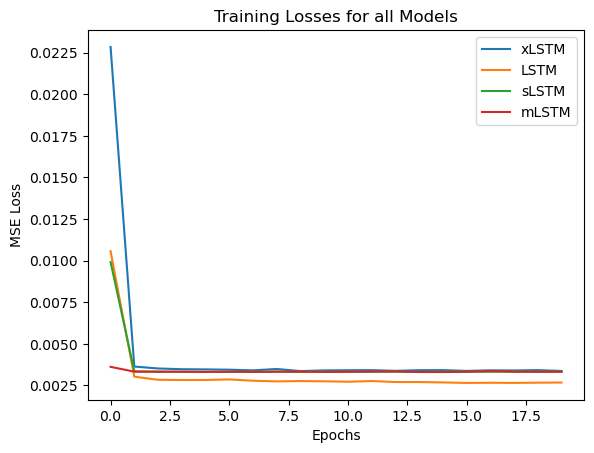

0.8128100304286422


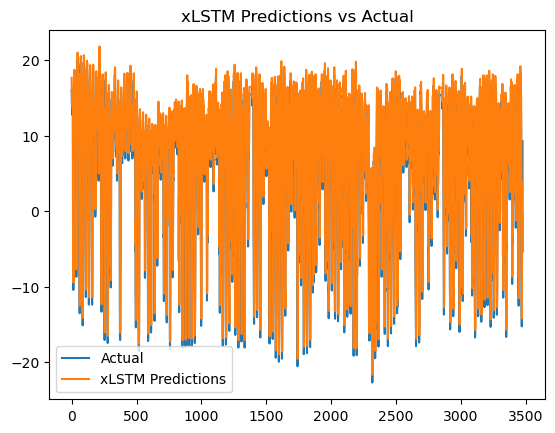

0.8721765499487466


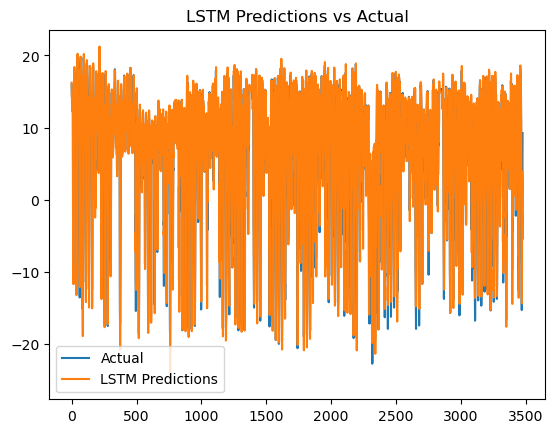

0.8225527570810003


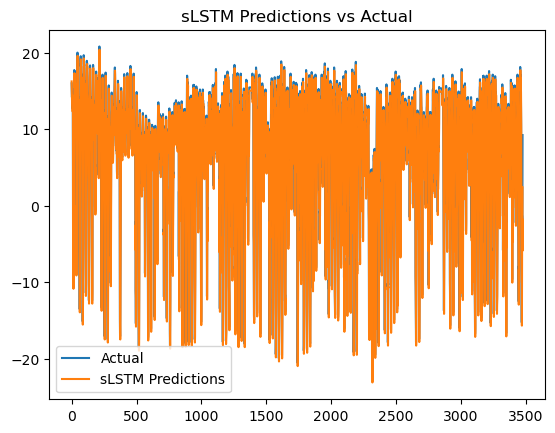

0.8237703644521905


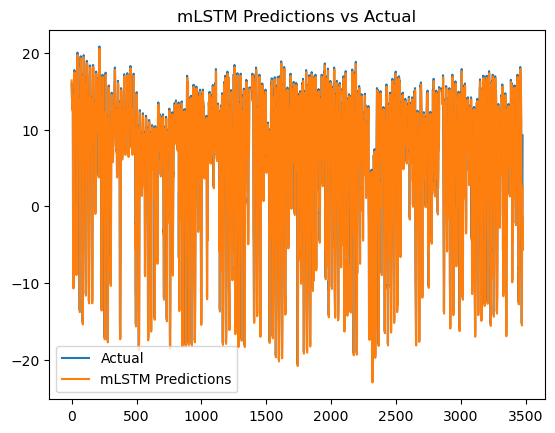

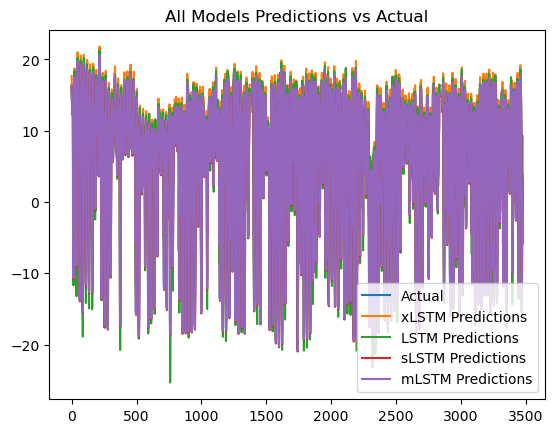

xLSTM : 0.8128100304286422
LSTM : 0.8721765499487466
sLSTM : 0.8225527570810003
mLSTM : 0.8237703644521905


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import torch.nn.functional as F


class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]


class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks

        assert out_features % num_blocks == 0

        block_out_features = out_features // num_blocks

        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x


class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4 / 3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor >0

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)

        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)

        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)

    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))

        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)


class sLSTM(nn.Module):
    # TODO: Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=4 / 3):
        super(sLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList(
            [sLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state


class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor >0

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)

        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)

        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)

        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        c_t = f * c_prev + i * (v * k)  # v @ k.T
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0]  # o * (c @ q) / max{|n.T @ q|, 1}

        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)


class mLSTM(nn.Module):
    # TODO: Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList(
            [mLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state


class xLSTM(nn.Module):
    # TODO: Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, proj_factor_slstm=4 / 3,
                 proj_factor_mlstm=2):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layers = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm

        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type: {layer_type}. Choose 's' for sLSTM or 'm' for mLSTM.")
            self.layers.append(layer)

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state


# In[3]:


# Dataset hyperparameters
batch_size = 32
seq_len = 8

# Load and preprocess the AirPassengers dataset
data = pd.read_csv('data\ETTh.csv', usecols=[1], engine='python')
print(data)
dataset = data.values.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]


def create_dataset(dataset, seq_len=8):
    dataX, dataY = [], []
    for i in range(len(dataset) - seq_len):
        a = dataset[i:(i + seq_len - 1)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len - 1])
    return torch.Tensor(dataX), torch.Tensor(dataY)


trainX, trainY = create_dataset(train, seq_len)
testX, testY = create_dataset(test, seq_len)

# Create data loaders
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model hyperparameters
input_size = 1
head_size = 32
num_heads = 2

# Define models
models = {
    "xLSTM": xLSTM(input_size, head_size, num_heads, batch_first=True, layers='msm'),
    "LSTM": nn.LSTM(input_size, head_size, batch_first=True, proj_size=input_size),
    "sLSTM": sLSTM(input_size, head_size, num_heads, batch_first=True),
    "mLSTM": mLSTM(input_size, head_size, num_heads, batch_first=True)
}


# Training process
def train_model(model, model_name, epochs=20, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    for epoch in tqdm(range(epochs), desc=f'Training {model_name}'):
        model.train()
        epoch_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs, _ = model(inputs)
            outputs = outputs[:, -1, :]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

    return model, train_losses


# Train the models
trained_models = {}
all_train_losses = {}
for model_name, model in models.items():
    trained_models[model_name], all_train_losses[model_name] = train_model(model, model_name)

# Plot losses for each model
plt.figure()
for model_name, train_losses in all_train_losses.items():
    plt.plot(train_losses, label=model_name)

# Plot all model losses compared
plt.title('Training Losses for all Models')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


# Evaluate models on test data
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs, _ = model(inputs)
            predictions.extend(outputs[:, -1, :].numpy())
    return predictions


test_predictions = {}
for model_name, model in trained_models.items():
    test_predictions[model_name] = evaluate_model(model, test_loader)
final_dict = {}
# Plot predictions for each model
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions and actual values
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    actual = scaler.inverse_transform(testY.numpy().reshape(-1, 1))
    print(r2_score(actual, preds))
    #print(preds)
    final_dict[model_name] = preds
    plt.figure()
    plt.plot(actual, label='Actual')
    plt.plot(preds, label=model_name + ' Predictions')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.legend()
    plt.show()

# Plot all model predictions compared
plt.figure()
plt.plot(actual, label='Actual')
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    plt.plot(preds, label=model_name + ' Predictions')

plt.title('All Models Predictions vs Actual')
plt.legend()
plt.show()

for i in final_dict:
    print(f"{i} : {r2_score(actual, final_dict[i])}")

